In [30]:
import pandas as pd  # data processing, CSV file I/O
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

# make a plot outputs appear and be stored within the notebook
%matplotlib inline

print("Complete")

Complete


In [31]:
LETTER_NAMES = {
    1: "alif",
    10: "ra",
    11: "zay",
    12: "sin",
    13: "shin",
    14: "sad",
    15: "dad",
    16: "da",
    17: "za",
    18: "ayn",
    19: "gayn",
    2: "ba",
    20: "fa",
    21: "qaf",
    22: "kaf",
    23: "lam",
    24: "mim",
    25: "non",
    26: "ha",
    27: "waw",
    28: "ya",
    29: "hamza",
    3: "ta",
    4: "tha",
    5: "gim",
    6: "ha",
    7: "kha",
    8: "dal",
    9: "thal"
}

In [32]:
x_train = pd.read_csv("./X_train.csv")
y_train = pd.read_csv("./y_train.csv")

In [33]:
print(x_train.columns)
print(y_train.columns)
assert len(x_train) == len(y_train)

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel1014', 'pixel1015', 'pixel1016', 'pixel1017', 'pixel1018',
       'pixel1019', 'pixel1020', 'pixel1021', 'pixel1022', 'pixel1023'],
      dtype='object', length=1024)
Index(['label'], dtype='object')


In [34]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37933 entries, 0 to 37932
Columns: 1024 entries, pixel0 to pixel1023
dtypes: int64(1024)
memory usage: 296.4 MB


In [35]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37933 entries, 0 to 37932
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   37933 non-null  int64
dtypes: int64(1)
memory usage: 296.5 KB


### Distributions

<AxesSubplot:>

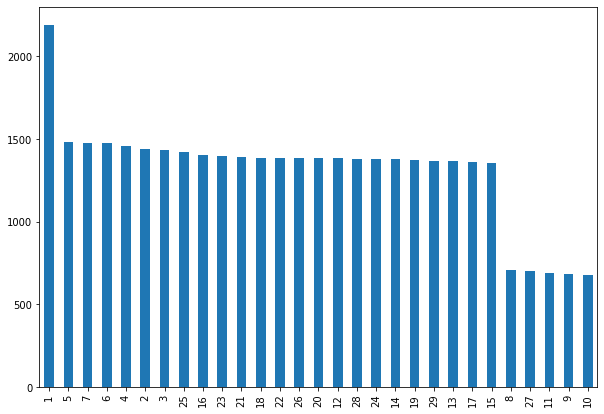

In [36]:
plt.figure(figsize=(10,7))
y_train['label'].value_counts().plot(kind="bar")

In [37]:
max([x_train[column].max() for column in x_train.columns] )

255

So each pixel takes value 0-255

### Changing data format to compatible with tf training

In [38]:
x_train_tf = tf.convert_to_tensor(x_train)
x_train_tf = x_train_tf / 255 # normalisation from 0 - 255 to 0 - 1
x_train_tf

<tf.Tensor: shape=(37933, 1024), dtype=float64, numpy=
array([[0.        , 0.        , 0.        , ..., 0.        , 0.01568627,
        0.02352941],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01176471, 0.04313725, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])>

### Test data
For assessing accuracy, loss, etc

In [39]:
x_test = pd.read_csv("./X_test.csv")
y_test = pd.read_csv("./y_test.csv")

In [40]:
x_test_tf = tf.convert_to_tensor(x_test)
x_test_tf = x_test_tf / 255 # normalisation from 0 - 255 to 0 - 1
y_test_tf = y_test - 1
y_test_tf

,label
0,0
1,0
2,0
3,0
4,0
...,...
9496,28
9497,28
9498,28
9499,28


### TF model

In [41]:
y_train_tf = y_train - 1
y_train_tf

,label
0,0
1,0
2,0
3,0
4,0
...,...
37928,28
37929,28
37930,28
37931,28


In [54]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

#### Best result
256,50,50 51%

In [68]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=1024))

    layer_count = hp.Int('layers', min_value=2, max_value=10, step=1)
    activation_functions= ['linear', 'relu', 'softmax', 'sigmoid']

    for i in range(layer_count):
        # Tune the number of units in the first Dense layer
        # Choose an optimal value between 4-1024
        hp_activations = hp.Choice(f'activation_function_{i}', values=activation_functions)
        hp_units = hp.Int(f'units_{i}', min_value=4, max_value=1024, step=4)
        model.add(tf.keras.layers.Dense(units=hp_units, activation=hp_activations))

    model.add(tf.keras.layers.Dense(29))

    model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

    return model

In [70]:
tuner = kt.Hyperband(model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    project_name='hyperparams')

In [71]:
tuner.search(x_train_tf, y_train_tf, epochs=50, validation_split=0.2, shuffle=True, use_multiprocessing=True)

Trial 30 Complete [00h 01m 01s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.007249242160469294
Total elapsed time: 00h 11m 19s
INFO:tensorflow:Oracle triggered exit


In [72]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

In [73]:
history = model.fit(x_train_tf, y_train_tf, epochs=300, callbacks=[stop_early], validation_split=0.2, shuffle=True, use_multiprocessing=True)

Epoch 1/300
949/949 [==============================] - 6s 6ms/step - loss: 2.5894 - accuracy: 0.2181 - val_loss: 11.9923 - val_accuracy: 0.0000e+00
Epoch 2/300
949/949 [==============================] - 6s 6ms/step - loss: 2.0629 - accuracy: 0.3492 - val_loss: 13.7536 - val_accuracy: 0.0000e+00
Epoch 3/300
949/949 [==============================] - 6s 6ms/step - loss: 1.8024 - accuracy: 0.4291 - val_loss: 16.5887 - val_accuracy: 0.0000e+00
Epoch 4/300
949/949 [==============================] - 6s 6ms/step - loss: 1.6163 - accuracy: 0.4811 - val_loss: 18.9884 - val_accuracy: 0.0000e+00
Epoch 5/300
949/949 [==============================] - 6s 6ms/step - loss: 1.4791 - accuracy: 0.5184 - val_loss: 18.3906 - val_accuracy: 1.3180e-04
Epoch 6/300
949/949 [==============================] - 6s 6ms/step - loss: 1.3803 - accuracy: 0.5473 - val_loss: 22.2550 - val_accuracy: 2.6361e-04
Epoch 7/300
949/949 [==============================] - 6s 6ms/step - loss: 1.3002 - accuracy: 0.5755 - val_loss:

In [74]:
test_loss, test_acc = model.evaluate(x_test_tf,  y_test_tf, verbose=2)

print('\nTest accuracy:', test_acc)

297/297 - 1s - loss: 37.1470 - accuracy: 0.4406 - 691ms/epoch - 2ms/step

Test accuracy: 0.440585196018219
